In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from piecewise import *


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [5]:
tf.enable_eager_execution()

## Settings

In [2]:
NP_DTYPE = np.float32

## Testing

In [6]:
test = PiecewiseLinear(6,3,5)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                975       
_________________________________________________________________
reshape (Reshape)            (None, 3, 5)              0         
Total params: 5,391
Trainable params: 5,391
Non-trainable params: 0
_________________________________________________________________


In [21]:
val = np.array(np.random.rand(1000000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))

True


In [26]:
np.allclose(test.forward_log_det_jacobian(val,event_ndims=1),-test.inverse_log_det_jacobian(forward,event_ndims=1))

False

In [11]:
test = PiecewiseQuadratic(6,3,5)

In [20]:
val = np.array(np.random.rand(1000,6),dtype=NP_DTYPE)
forward = test.forward(val)
inverse = test.inverse(forward)
print(np.allclose(val,inverse.numpy()))
print(((val-inverse.numpy())/val)[np.logical_not(np.isclose(val,inverse.numpy()))])

True
[]


## Training

In [27]:
tf.disable_eager_execution()

In [3]:
bijectors = []

for i in range(2):
    bijectors.append(PiecewiseLinear(2,1,5,layer_id=i))
    bijectors.append(tfb.Permute(permutation=[1,0]))

# Discard the last Permute layer
test_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
_________________________________________________________________
reshape (Reshape)            (None, 1, 5)              0         
Total params: 4,613
Trainable params: 4,613
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
The TensorFlow Distributions library has 

In [4]:
base_dist = tfd.Uniform(low=[0.0,0.0],high=[1.0,1.0])
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=test_bijector,
)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [5]:
x = base_dist.sample(1000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

In [6]:
sess = tf.InteractiveSession()

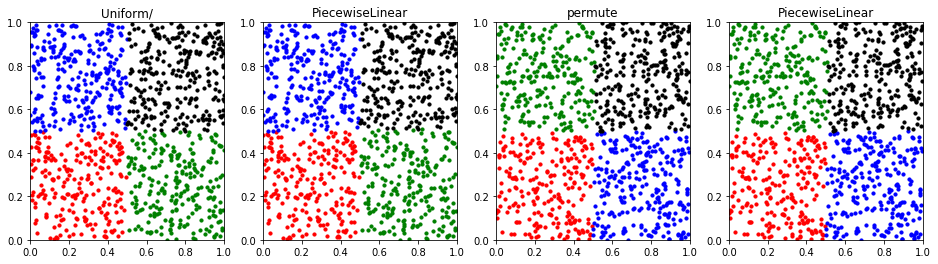

In [7]:
sess.run(tf.global_variables_initializer())
results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4*len(results),4))
X0 = results[0]
for i in range(len(results)):
    X1 = results[i]
    idx = np.logical_and(X0[:,0] < 0.5, X0[:,1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] < 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0.5, X0[:, 1] > 0.5)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    arr[i].set_xlim([0, 1])
    arr[i].set_ylim([0, 1])
    arr[i].set_title(names[i])

In [10]:
def dsigma(x):
    return tf.where(tf.logical_and(x[:,0] < tf.ones_like(x[:,0])*0.9,x[:,1] < tf.ones_like(x[:,0])*0.9), (x[:,0]**2 + x[:,1]**2)/((1-x[:,0])*(1-x[:,1])), tf.zeros_like(x[:,0]))

In [26]:
samples = np.array(np.random.rand(10000,2),dtype=NP_DTYPE)
x = sess.run(bijector.inverse(samples))
X = sess.run(bijector.pdf(x))
dsig = sess.run(dsigma(x))
print(tf.reduce_prod(X,axis=-1), '\n', dsig)

Tensor("Prod_18:0", shape=(10000,), dtype=float32) 
 [26.389877    5.306424    0.         ...  0.          0.7024538
  0.02649752]


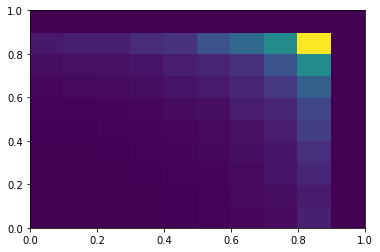

In [27]:
plt.hist2d(x[:,0],x[:,1],weights=dsig)
plt.show()

ValueError: object of too small depth for desired array

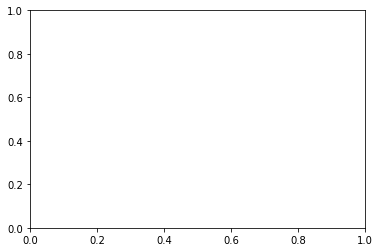

In [18]:
plt.hist2d(x[:,0],x[:,1],weights=tf.reduce_prod(X,axis=-1)*tf.exp(sess.run(bijector.forward_log_det_jacobian(x,event_ndims=1))))
plt.show()

In [19]:
loss = -tf.reduce_mean(dsig*tf.log(tf.reduce_prod(X,axis=-1)))
print(loss)

Tensor("Neg:0", shape=(), dtype=float32)


In [20]:
def loss_fn(x):
    x = bijector.inverse(x)
    q = tf.reduce_prod(bijector.pdf(x),axis=-1)
    p = dsigma(x)
    return -tf.reduce_mean(p*(tf.log(q)+bijector.forward_log_det_jacobian(x,event_ndims=1)))

In [21]:
def grad(x):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(x)
    return loss_value, tape.gradient(loss_value, bijector.trainable_variables)

In [28]:
optimizer = tf.train.AdamOptimizer(1e-4)
global_step = tf.Variable(0)

loss_value, grads = grad(samples)

print(sess.run(grads))


[array([[ 0.05472853, -0.13298339,  0.        ,  0.        , -0.0200726 ,
        -0.04050285, -0.08357017,  0.        ,  0.        ,  0.        ,
         0.06023222,  0.        ,  0.        ,  0.        , -0.01914733,
         0.06464516,  0.        , -0.07765307,  0.        ,  0.        ,
         0.05384785,  0.        ,  0.        ,  0.08772331,  0.        ,
         0.        ,  0.01000423,  0.        ,  0.        ,  0.        ,
         0.        , -0.02729185,  0.        ,  0.05101434,  0.        ,
         0.        ,  0.14862019,  0.14684494,  0.        , -0.02137603,
         0.02400061,  0.        ,  0.01116005,  0.        ,  0.03293768,
         0.        ,  0.        , -0.01985373,  0.        ,  0.        ,
         0.05590658,  0.        , -0.00506232,  0.        , -0.04957676,
         0.        , -0.14294842,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32), array([ 0.07076281, -0.17751236,  0.   